# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="school_batches",
                                        batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_ = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1},
                  num_document_passes=1, cache_theta=True) #cache_theta=False будет выдавать ошибку на get_theta

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_.scores.add(artm.TopTokensScore(name='text_score', num_tokens=15, class_id='text'))
model_.scores.add(artm.TopTokensScore(name='author_score',num_tokens=15, class_id='author'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
tau = 1e5
model_.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=tau, dictionary=dictionary, 
                                                        class_ids='text', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
# Ваш код
tau=-1e5
model_.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau, dictionary=dictionary,
                                                       class_ids='text', topic_names=topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [12]:
# Ваш код
model_.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [19]:
# Ваш код
for topic_name in model_.topic_names:
    print(topic_name, ': ', end=' ')
    [print(item, end=' ') for item in model_.score_tracker['text_score'].last_tokens[topic_name]]
    print('\n')

sbj0 :  его власть александр писать историк имя великий римский знаменитый король церковь реформа средневековый над мысль 

sbj1 :  там раз планета земля интересный находиться температура тело открывать маленький обнаруживать образовываться вокруг вода атмосфера 

sbj2 :  система чтобы между создавать сложный общий направление простой движение ответ способность трудность переход сложно искусственный 

sbj3 :  говорить сторона понятие связанный всегда отвечать лицо представление предмет отличаться концепция опыт меняться восприятие рассматривать 

sbj4 :  должный вид появляться каждый вещь любой иной качество мой нельзя особый этап оценка никто очередь 

sbj5 :  можно при получать структура материал использовать сделать достаточно свойство элемент огромный пора применение устройство сей 

sbj6 :  книга научный написать выходить тема автор фильм массовый абсолютно документ герой брать обращать молодой театр 

sbj7 :  сам социальный кто после общество принимать считать степень род социоло

In [18]:
for topic_name in model_.topic_names:
    print(topic_name, ': ', end=' ')
    [print(item, end=' ') for item in model_.score_tracker['author_score'].last_tokens[topic_name]]
    print('\n')

sbj0 :  Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Ольга_Вайнштейн Михаил_Бойцов Алексей_Юдин Игорь_Данилевский Раиса_Кирсанова Владимир_Кантор Елена_Браун Игорь_Курукин Елена_Уханова Екатерина_Болтунова Арчил_Балахванцев 

sbj1 :  Елизавета_Бонч-Осмоловская Кирилл_Еськов Сергей_Попов Дмитрий_Титов Николай_Пименов Татьяна_Смоктунович Андрей_Иванцов Зоригто_Намсараев Светлана_Дедыш Александр_Марков Сергей_Наугольных Юлия_Краус Александр_Слободкин Елизавета_Ривкина Наталья_Новикова 

sbj2 :  Александр_Поддьяков Дмитрий_Громов Михаил_Пантелеев Владимир_Мележик Варвара_Веденина Даниэль_Сельва Антон_Суворов Михаил_Фейгельман Виталий_Пальчиков Кирилл_Зыбин Алексей_Котов Кристофер_Уиншип Андрей_Шевельков Александра_Скрипченко Андрей_Чабовский 

sbj3 :  Виталий_Куренной Сергей_Арутюнов Владимир_Миронов Максим_Кронгауз Алексей_Руткевич Николай_Плотников Павел_Степанцов Дмитрий_Куракин Дмитрий_Иванов Фёдор_Гиренок Татьяна_Котова Михаил_Маяцкий Ирина_Каспэ Андрей_Коротаев Г

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [33]:
sbj_topic_labels = ['История Александра', 'Космос', 'Искусственное движение', 'Разговоры', 'Внешний вид',
                   'Структуры материалов', 'Синемалогия', 'Социология', 'Наука', 'Квантовая физика',
                   'Постапок', 'Деторождение', 'Нейроны мозга', 'Древние государства', 'Вселенная',
                   'Информация', 'Расы', 'Философия', 'Русский язык', 'Школа',
                   'Городское будущее', 'Болезни', 'Познание', 'Математика', 'Мифология',
                   'Языки', 'Экономика', 'Генетика', 'Образование']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [22]:
model_.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_.get_theta()
phi_a = model_.get_phi(class_ids='author')

In [23]:
phi_a 

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Ярослав_Исполатов)",0.000000e+00,0.000000e+00,2.615842e-09,2.649637e-11,1.272682e-06,0.000000e+00,0.000000e+00,0.000000e+00,1.417607e-10,0.000000e+00,...,0.000000e+00,1.054296e-07,2.838238e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.073612e-14,1.097035e-10,5.793622e-03
"(author, Сергей_Демокритов)",0.000000e+00,0.000000e+00,2.020956e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.096716e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.543076e-12,2.239799e-11
"(author, Руслан_Смелянский)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.323879e-02,0.000000e+00,...,5.551938e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"(author, Александр_Апт)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.323819e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.498812e-07,0.000000e+00,7.051044e-10
"(author, Людмила_Новикова)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.315597e-16,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.406548e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.748611e-08
"(author, Александр_Парфенов)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.193422e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
"(author, Джеффри_Шнапп)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.661744e-05,0.000000e+00,1.481667e-10,0.000000e+00,...,1.237897e-09,0.000000e+00,3.640730e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.271730e-05,2.502215e-08
"(author, Дмитрий_Чудаков)",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.471246e-10,0.000000e+00,...,0.000000e+00,1.978438e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.993128e-02,0.000000e+00,0.000000e+00
"(author, Дмитрий_Дождев)",0.000000e+00,0.000000e+00,0.000000e+00,1.475986e-07,3.309142e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.413396e-09
"(author, Владимир_Шалаев)",0.000000e+00,0.000000e+00,1.802836e-14,0.000000e+00,0.000000e+00,5.472084e-02,0.000000e+00,0.000000e+00,3.441437e-09,7.190397e-15,...,1.301380e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.607802e-14,6.452194e-09


In [24]:
theta

,http://postnauka.ru/video/53046,http://postnauka.ru/video/53169,http://postnauka.ru/video/53171,http://postnauka.ru/video/532,http://postnauka.ru/video/53228,http://postnauka.ru/video/53298,http://postnauka.ru/video/53342,http://postnauka.ru/video/53364,http://postnauka.ru/video/53386,http://postnauka.ru/video/53415,...,http://postnauka.ru/video/59622,http://postnauka.ru/video/59627,http://postnauka.ru/video/59632,http://postnauka.ru/video/59633,http://postnauka.ru/video/59636,http://postnauka.ru/video/59638,http://postnauka.ru/video/5990,http://postnauka.ru/video/5999,http://postnauka.ru/video/60481,http://postnauka.ru/video/60527
sbj0,0.035727,0.025921,0.000000,0.012593,0.233958,0.006542,0.009643,0.031239,0.005993,0.000000,...,0.015983,0.011986,0.003097,0.006919,0.014117,0.006550,5.449979e-03,0.017700,0.010924,0.008120
sbj1,0.005526,0.015482,0.025246,0.016831,0.015964,0.010865,0.022120,0.025708,0.028002,0.027848,...,0.041626,0.062034,0.008754,0.016341,0.025436,0.020225,5.818850e-03,0.015611,0.047981,0.011389
sbj2,0.011484,0.000000,0.000000,0.008481,0.008620,0.040670,0.020065,0.030392,0.023681,0.139209,...,0.008945,0.024118,0.029513,0.027165,0.025958,0.012307,2.366380e-02,0.003433,0.017800,0.015082
sbj3,0.038378,0.015646,0.025326,0.012720,0.015361,0.003984,0.005205,0.017361,0.006347,0.056477,...,0.037579,0.026573,0.012013,0.007382,0.011108,0.049330,5.931700e-03,0.021533,0.012644,0.017475
sbj4,0.019166,0.010426,0.000000,0.017635,0.006057,0.023556,0.024255,0.021673,0.019060,0.000000,...,0.030586,0.010936,0.018566,0.035181,0.001675,0.016374,2.368805e-02,0.010260,0.010482,0.012482
sbj5,0.007567,0.000000,0.000000,0.018973,0.024515,0.053646,0.081944,0.002346,0.089335,0.000000,...,0.021749,0.011926,0.017322,0.020469,0.014668,0.012183,4.099920e-02,0.003390,0.021410,0.022146
sbj6,0.069337,0.010475,0.000000,0.004230,0.030441,0.005915,0.008444,0.008711,0.007319,0.002688,...,0.010931,0.010508,0.008689,0.004070,0.022175,0.003984,0.000000e+00,0.020666,0.003535,0.007934
sbj7,0.030597,0.000000,0.000000,0.021150,0.030722,0.011482,0.007725,0.030219,0.009377,0.000000,...,0.022006,0.011991,0.005428,0.008633,0.003665,0.036925,5.871165e-03,0.023834,0.009779,0.009674
sbj8,0.011454,0.020725,0.075737,0.054696,0.001909,0.044561,0.050789,0.011054,0.035876,0.028109,...,0.015558,0.012033,0.025173,0.024876,0.018469,0.044927,3.540013e-02,0.030667,0.005575,0.018956
sbj9,0.011443,0.035412,0.024652,0.012313,0.001863,0.019802,0.018444,0.017049,0.049856,0.000000,...,0.018166,0.026315,0.014997,0.032068,0.026727,0.008152,3.328002e-02,0.015611,0.158531,0.027452


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

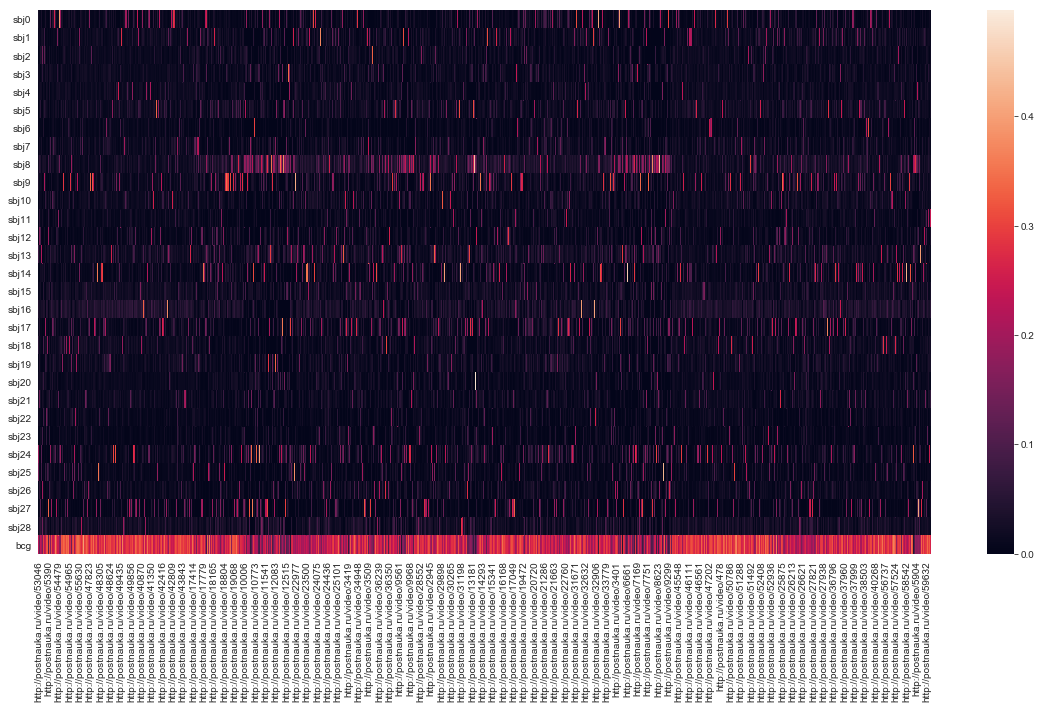

In [31]:
# Ваш код
fig, ax = plt.subplots(figsize=(20,10))
seaborn.heatmap(theta[:100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [42]:
# Ваш код
pt = theta.sum(axis=1)/theta.sum(axis=1).sum()
pt.index = topic_labels
pt.sort_values(ascending=False)

Фоновая тема              0.250729
Наука                     0.055328
Квантовая физика          0.036891
Мифология                 0.036491
Древние государства       0.036293
Философия                 0.034381
Расы                      0.034354
Вселенная                 0.032803
Генетика                  0.030220
Образование               0.028928
Космос                    0.028677
Структуры материалов      0.028498
История Александра        0.027531
Экономика                 0.024497
Информация                0.024492
Постапок                  0.024177
Социология                0.023263
Русский язык              0.022125
Школа                     0.022032
Нейроны мозга             0.022012
Болезни                   0.021492
Языки                     0.020515
Разговоры                 0.020291
Внешний вид               0.019409
Искусственное движение    0.018409
Городское будущее         0.017743
Деторождение              0.017137
Синемалогия               0.014117
Познание            

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

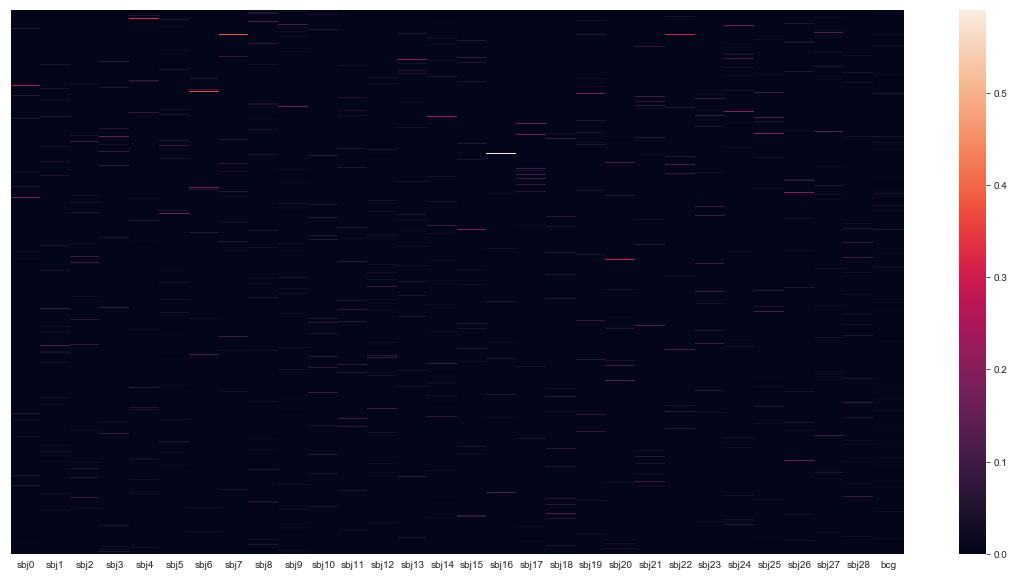

In [50]:
# Ваш код
fig, ax = plt.subplots(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [48]:
(phi_a > 0.01).sum(axis=1).sort_values().tail(10)

(author, Владимир_Плунгян)    2
(author, Ирина_Савельева)     2
(author, Михаил_Соколов)      2
(author, Виталий_Куренной)    3
(author, Михаил_Киселев)      3
(author, Елена_Брызгалина)    3
(author, Михаил_Гельфанд)     3
(author, Владимир_Муронец)    3
(author, Михаил_Маяцкий)      3
(author, Виктор_Вахштайн)     4
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [51]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [57]:
# Ваш код
d = phi_a * pt[1]
author_map = d / d.sum(axis=1)[1]

Визуализируйте найденные двумерные представления с помощью функции scatter. 

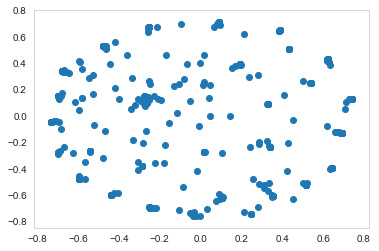

In [58]:
# Ваш код
dist = pairwise_distances(author_map, metric = 'cosine')
MDS_ = MDS(dissimilarity="precomputed")
MDS_tf = MDS_.fit_transform(dist)
plt.scatter(MDS_tf[:,0], MDS_tf[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [59]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

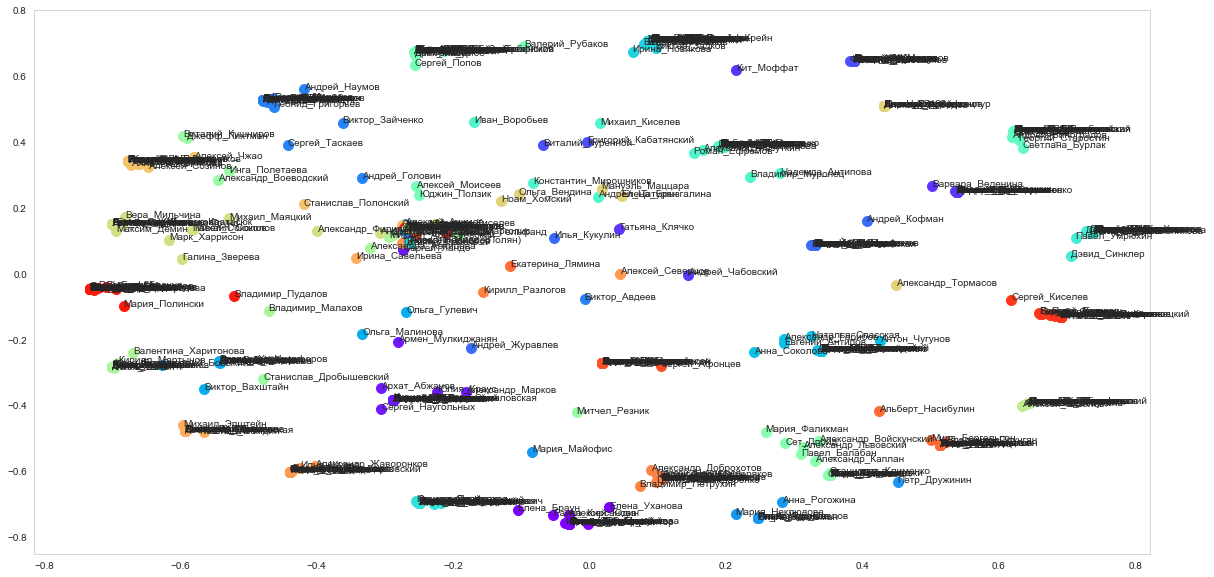

In [78]:
df = pd.DataFrame(colors, index = phi_a.columns)
fig, ax = plt.subplots(figsize=(20,10))
for i in range(author_map.shape[0]):
    plt.scatter(MDS_tf[i, 0], MDS_tf[i, 1], c = df.loc[phi_a.iloc[i,:-1].idxmax(),:].values, s=100)
    plt.annotate(author_map.index[i][-1], xy=[MDS_tf[i, 0], MDS_tf[i, 1]])
plt.savefig('map.pdf')          

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [69]:
# Ваш код
pd_ = theta/theta.sum(axis=1)[-1]
pd_.head()

,http://postnauka.ru/video/53046,http://postnauka.ru/video/53169,http://postnauka.ru/video/53171,http://postnauka.ru/video/532,http://postnauka.ru/video/53228,http://postnauka.ru/video/53298,http://postnauka.ru/video/53342,http://postnauka.ru/video/53364,http://postnauka.ru/video/53386,http://postnauka.ru/video/53415,...,http://postnauka.ru/video/59622,http://postnauka.ru/video/59627,http://postnauka.ru/video/59632,http://postnauka.ru/video/59633,http://postnauka.ru/video/59636,http://postnauka.ru/video/59638,http://postnauka.ru/video/5990,http://postnauka.ru/video/5999,http://postnauka.ru/video/60481,http://postnauka.ru/video/60527
sbj0,0.000082,0.000060,0.000000,0.000029,0.000540,0.000015,0.000022,0.000072,0.000014,0.000000,...,0.000037,0.000028,0.000007,0.000016,0.000033,0.000015,0.000013,0.000041,0.000025,0.000019
sbj1,0.000013,0.000036,0.000058,0.000039,0.000037,0.000025,0.000051,0.000059,0.000065,0.000064,...,0.000096,0.000143,0.000020,0.000038,0.000059,0.000047,0.000013,0.000036,0.000111,0.000026
sbj2,0.000027,0.000000,0.000000,0.000020,0.000020,0.000094,0.000046,0.000070,0.000055,0.000321,...,0.000021,0.000056,0.000068,0.000063,0.000060,0.000028,0.000055,0.000008,0.000041,0.000035
sbj3,0.000089,0.000036,0.000058,0.000029,0.000035,0.000009,0.000012,0.000040,0.000015,0.000130,...,0.000087,0.000061,0.000028,0.000017,0.000026,0.000114,0.000014,0.000050,0.000029,0.000040
sbj4,0.000044,0.000024,0.000000,0.000041,0.000014,0.000054,0.000056,0.000050,0.000044,0.000000,...,0.000071,0.000025,0.000043,0.000081,0.000004,0.000038,0.000055,0.000024,0.000024,0.000029


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [62]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [63]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [79]:
# Ваш код
dict_={}
for i in range(pd_.shape[0]-1):
    a = pd_.iloc[i,:].sort_values(ascending=False).head(10)
    dict_[pd_.index[i]] = list(a.index)
    
tokens = model_.score_tracker["text_score"].last_tokens

for i, topic in enumerate(pd_.index):    
    display(HTML(f"<h2>{topic_labels[i]}</h2>"))
    display(HTML(f"<ul><li>{tokens[topic][:10]}</li></ul>"))
    for j in dict_[topic]:
        display(HTML(f'<a href={j}">{j}</a>'))

KeyError: 'bcg'

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 